#**Модель прогнозирования неактивных клиентов на заданном наборе данных.**

 # CRISP-DM:

# Business Understanding
## Бизнес-цели:


###*   Снижение оттока клиентов банка
###*   Увеличение прибыли за счет удержания существующих клиентов




### Ситуация:
### Банк «Метанпром» теряет клиентов, что приводит к снижению доходов. Стоимость привлечения нового клиента выше, чем удержание существующего.

## Цели анализа данных:

### Построить модель, предсказывающую вероятность ухода клиента

### Выявить ключевые факторы, влияющие на отток клиентов


##План проекта:

###1.Загрузка и анализ данных

###2.Предобработка данных

###3.Разведочный анализ (EDA)

###4.Построение и оценка моделей

###5.Интерпретация результатов



# 1. Загрузка и анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

### Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

### Описание данных: Файл bank_scrooge.csv:

*   USERID — идентификатор пользователя,
*   score — баллы кредитного скоринга,
*   city — город,
*   gender — пол,
*   age — возраст,
*   equity — количество баллов собственности
*   balance — баланс на счёте,
*   products — количество продуктов, которыми пользуется клиент,
*   credit_card — есть ли кредитная карта,
*   last_activity — активный клиент,
*   EST_SALARY — оценочный доход клиента,
*   сhurn — признак оттока


In [ ]:
data = pd.read_csv('/content/bank_scrooge.csv')

In [ ]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.000,Рыбинск,Ж,25.000,1,"59,214.820",2,0,1,"75,719.140",1
1,146556,861.000,Рыбинск,Ж,37.000,5,"850,594.330",3,1,0,"86,621.770",0
2,120722,892.000,Рыбинск,Ж,30.000,0,NaN,1,1,1,"107,683.340",0
3,225363,866.000,Ярославль,Ж,51.000,5,"1,524,746.260",2,0,1,"174,423.530",1
4,157978,730.000,Ярославль,М,34.000,5,174.000,1,1,0,"67,353.160",1


In [ ]:
data.shape

(10000, 12)

В датафрейме информация о 10 тысячах клиентов, характеризующиеся 12 параметрами, среди которых являются булевыми: наличие кредитной карты у клиента, проявлял ли он активность в последнее время и собирается ли он покидать банк

Изучим общую информацию о датасете:

In [ ]:
print("\nИнформация о данных:")
print(data.info())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None


Есть только 2 строковых столбца - город и пол.

В предобработке данных возраст измененим с вещественного на целочисленный

Общая характеристики числовых данных:

In [ ]:
pd.options.display.float_format ='{:,.3f}'.format
data.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,"10,000.000","10,000.000","9,974.000","10,000.000","7,705.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000"
mean,"171,814.713",848.699,42.734,2.628,"827,794.307",1.870,0.680,0.523,"147,866.886",0.182
std,"33,708.238",65.449,12.180,1.981,"1,980,614.147",0.793,0.466,0.499,"139,388.511",0.386
min,"94,561.000",642.000,18.000,0.000,0.000,0.000,0.000,0.000,"2,546.300",0.000
25%,"142,810.250",802.000,33.000,0.000,"295,554.160",1.000,0.000,0.000,"75,251.900",0.000
50%,"172,728.000",853.000,40.000,3.000,"524,272.200",2.000,1.000,1.000,"119,658.105",0.000
75%,"201,261.750",900.000,51.000,4.000,"980,705.850",2.000,1.000,1.000,"174,500.542",0.000
max,"229,145.000","1,000.000",86.000,9.000,"119,113,552.010",5.000,1.000,1.000,"1,395,064.450",1.000


In [ ]:
"""
Доля ушедших клиентов: 18% (целевая переменная)
Распределение классов требует балансировки при построении модели
Выводы по данным:
Наблюдается значительная вариативность по финансовым показателям (балансы, доходы)
Требуется обработка экстремальных значений в финансовых показателях
Необходимо исследовать аномалии (клиенты с 0 продуктов)
Присутствует умеренный дисбаланс классов в целевой переменной
Данные демонстрируют типичное для банковского сектора распределение характеристик
"""

In [ ]:
cities = pd.DataFrame(data.groupby('city')['USERID'].count().sort_values(ascending=False))
cities['rate'] = data.groupby('city')['USERID'].count().sort_values(ascending=False)/data['USERID'].count()*100
cities.columns=['cnt_users', 'rate']
cities

,cnt_users,rate
city,,
Ярославль,5888,58.880
Рыбинск,2695,26.950
Ростов,1417,14.170


Филиалы банка находятся в Рыбинске, Ярославле и Ростове. Больше всего клиентов в отделении Ярославля, 59%, в Рыбинске в - 27%, а в Ростове 14%

In [ ]:
gender = pd.DataFrame(data.groupby('gender')['USERID'].count().sort_values(ascending=False))
gender['rate'] = data.groupby('gender')['USERID'].count().sort_values(ascending=False)/data['USERID'].count()*100
gender.columns=['cnt_users', 'rate']
gender

,cnt_users,rate
gender,,
М,5005,50.050
Ж,4995,49.950


Данные распределены поровну, по 50% мужчин и женщин

# 2.Предобработка данных

Названия столбцов приведем к общепринятым норамам

In [ ]:
data.columns = data.columns.str.lower()
data.rename(columns={'userid':'user_id'}, inplace=True) #к названию столбца с уникальным идентификатором добавим еще нижнее подчеркивание
data.head(0)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


Поработаем с пропусками в данных:

In [ ]:
print("Проценты, доли пропусков от общего количества:")
(data.isna().sum()/data.count()*100).sort_values(ascending=False)

Проценты, доли пропусков от общего количества:


,0
balance,29.786
age,0.261
user_id,0.000
score,0.000
gender,0.000
city,0.000
equity,0.000
products,0.000
credit_card,0.000
last_activity,0.000


Пропуски присутствуют только в двух столбцах:

возраст - 0.26%,
количество средств на балансе - 29.8%

Удаляем пропуски в столбце возраст:

In [ ]:
data = data.dropna(subset=['age'])
(data.isna().sum()/data.count()*100).sort_values(ascending=False)

,0
balance,29.617
user_id,0.000
city,0.000
score,0.000
gender,0.000
age,0.000
equity,0.000
products,0.000
credit_card,0.000
last_activity,0.000


Пропуски в балансе:

Изучим подробнее пропуски в балансах. Может быть, так что так отображается нулевой баланс, чтобы это узнать посмотрим есть ли в данных баланс со значением 0

In [ ]:
data[data['balance']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3900,179831,730.000,Ярославль,М,18.000,0,0.000,2,1,1,"64,548.330",0
6757,148456,813.000,Ярославль,М,20.000,2,0.000,2,1,0,"23,876.510",0


Таких клиентов всего 2

 Посмотрим еще на распределение отсутствующих значений баланса по отточным клиентам

In [ ]:
data[data['balance'].isna()].groupby('churn').agg({'user_id':'count'})

,user_id
churn,
0,2266
1,13


Из всех пропусков уходящих клиентов толкьо 13, значит дело не в том, что их баланс решили удалить

In [ ]:
data[data['balance'].isna()].describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"2,279.000","2,279.000","2,279.000","2,279.000",0.000,"2,279.000","2,279.000","2,279.000","2,279.000","2,279.000"
mean,"171,904.886",865.357,42.093,0.051,NaN,1.163,0.815,0.549,"226,345.417",0.006
std,"33,303.215",89.554,11.942,0.227,NaN,0.404,0.388,0.498,"199,825.591",0.075
min,"114,182.000",642.000,18.000,0.000,NaN,0.000,0.000,0.000,"20,274.030",0.000
25%,"142,992.500",871.000,33.000,0.000,NaN,1.000,1.000,0.000,"120,217.385",0.000
50%,"172,304.000",903.000,40.000,0.000,NaN,1.000,1.000,1.000,"174,347.870",0.000
75%,"201,257.000",922.000,49.000,0.000,NaN,1.000,1.000,1.000,"240,372.775",0.000
max,"229,145.000",990.000,86.000,3.000,NaN,3.000,1.000,1.000,"1,333,687.360",1.000


Пропуски в балансе в основном у клиентов, средний доход которых 226 тысяч,а медианный 174 тысячи.

Text(0, 0.5, 'Количетсво клиентов')

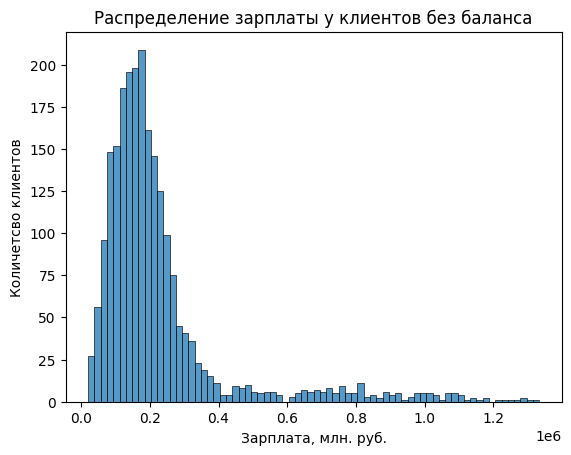

In [ ]:
sns.histplot(data[data['balance'].isna()]['est_salary'])
plt.title('Распределение зарплаты у клиентов без баланса')
plt.xlabel('Зарплата, млн. руб.')
plt.ylabel('Количетсво клиентов')

В распределении зарплат людей с отсутствующим балансом нет ничего выделяющегося.

Оставим пропуски в столбце с балансом, так как заполнение денежных значений медианой или средним значением может быть  некорректным. В 30% случаев данные отсутствуют, это значительная доля.

Поробуем проанализировать распределение некоторых параметров у клиентов с пропусками в балансе, возможно, там получится выявить какие-либо закономерности.

Количество продуктов:

In [ ]:
100*data[data['balance'].isna()]['products'].value_counts()/data[data['balance'].isna()]['user_id'].count()

,count
products,
1,84.862
2,13.822
3,1.272
0,0.044


Большинство клиентов, 84.9%, с пропуском баланса имеют 1 продукт банка.

Собственность:

In [ ]:
100*data[data['balance'].isna()]['equity'].value_counts()/data[data['balance'].isna()]['user_id'].count()

,count
equity,
0,94.954
1,5.002
3,0.044


У 95% клиентов c пропусками в балансе недвижимости нет.

Построим еще гистограмму баллов скоринга таких клиентов:

Text(0, 0.5, 'Количетсво клиентов')

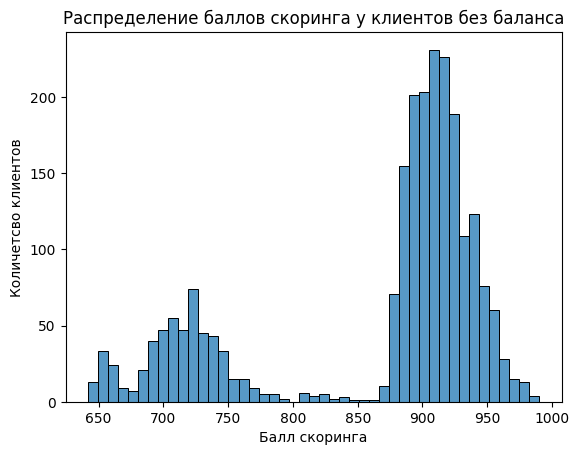

In [ ]:
sns.histplot(data[data['balance'].isna()]['score'])
plt.title('Распределение баллов скоринга у клиентов без баланса')
plt.xlabel('Балл скоринга')
plt.ylabel('Количетсво клиентов')

У клиентов нет собственности, а баллы скоринга достаточно высоки.

Посмотрим еще на возраст клиентов

Text(0, 0.5, 'Количетсво клиентов')

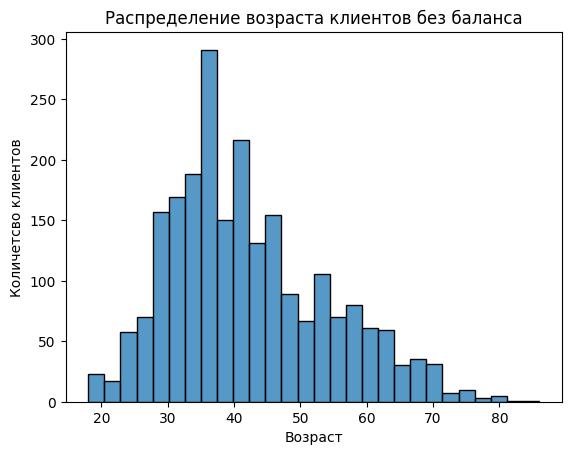

In [ ]:
sns.histplot(data[data['balance'].isna()]['age'])
plt.title('Распределение возраста клиентов без баланса')
plt.xlabel('Возраст')
plt.ylabel('Количетсво клиентов')

In [ ]:
data[data['balance'].isna()]['age'].value_counts().head(10)

,count
age,
36.000,104
33.000,99
37.000,97
35.000,90
34.000,89
32.000,89
31.000,80
42.000,78
40.000,78


Выявляется следующая закономерность: клиенты, у которых отсутствует баланс на счете в большинстве своем - люди от 30 до 40 лет, у них нет ничего дорогово в собственности, однако есть кредитка нашего банка и, вероятно, хороший балл скоринга за ее счет, также они не собираются покидать банк.

Переведем тип данных в возрасте в целочисленный

In [ ]:
data['age'] = data['age'].astype('int')

Проверим на дубликаты:

In [ ]:
data.duplicated().sum()

np.int64(0)

Проверка на дубликаты в идентификаторах клиентов

In [ ]:
print('Количество дубликатов иденификаторов', data[['user_id']].duplicated().sum(),'\n')
print('Максимальное количетсво повторений айдишника\n', data['user_id'].value_counts().sort_values(ascending=False).head(),'\n')

Количество дубликатов иденификаторов 50 

Максимальное количетсво повторений айдишника
 user_id
208081    2
217412    2
150667    2
117943    2
191520    2
Name: count, dtype: int64 



Всего в данных повторяется 50 айдишников и максимально 2 вхождения. Посмотрим на данные клиентов с однаковыми айдишниками

Посмотрим на данные клиентов с однаковыми айдишниками

In [ ]:
dubl_id = data[data[['user_id']].duplicated(keep=False)].sort_values(by=['user_id', 'city', 'gender'])
dubl_id.head(50)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.000,Рыбинск,Ж,55,1,"362,756.490",3,0,1,"175,920.480",1
7694,116540,887.000,Ярославль,Ж,38,0,NaN,1,0,1,"119,247.610",0
4866,117943,855.000,Рыбинск,Ж,32,6,"1,036,832.930",4,1,1,"107,792.710",1
7542,117943,880.000,Ярославль,Ж,40,0,NaN,1,1,0,"137,718.930",0
5863,120258,908.000,Рыбинск,Ж,38,4,"2,213,581.630",2,0,1,"160,327.770",1
5896,120258,905.000,Ярославль,М,30,0,NaN,1,1,1,"146,427.960",0
8638,123461,934.000,Рыбинск,М,34,0,NaN,2,1,0,"291,619.270",0
1411,123461,829.000,Ярославль,Ж,59,0,"96,222.440",2,0,1,"102,771.550",1
9775,124450,758.000,Рыбинск,Ж,36,0,"73,574.070",2,0,1,"79,963.590",0
8164,124450,859.000,Ярославль,Ж,38,6,"516,811.200",1,1,1,"95,144.630",1


In [ ]:
dubl_id['city'].value_counts()

,count
city,
Рыбинск,50
Ярославль,50


В одном городе идентификаторы клиентов уникальны и не повторяются, при этом в каждом городе есть по 50 различных идентификаторов. Можно выделить несколько интересных закономерностей:

Некоторые идентификаторы имеют схожие основные параметры, но при этом наблюдается увеличение количества банковских продуктов, появление средств на балансе и увеличение возраста клиентов. Это может указывать на то, что клиент обращался в отделения банка в разных городах, что привело к случайному созданию нескольких записей. Однако объяснить различия в половой принадлежности в таких случаях не удается.

Также встречаются идентификаторы, у которых пол различается, а другие параметры значительно отличаются и не имеют близких значений (например, клиенты с user_id=164676).

Кроме того, у клиентов с одинаковыми идентификаторами признаки оттока не совпадают.

Раз нужно выявить отточных клиентов, оставим среди дублей тех, кто является отточным.

In [ ]:
dubl_id = dubl_id.query('churn==0')
dubl_id.reset_index(inplace=True)
data.drop(dubl_id['index'], inplace=True)
data[['user_id']].duplicated().sum()

np.int64(0)

Повторов идентификаторов не осталось.

Проверка на аномалии в количестве продуктов банка

Посмотрим, как количетсво продуктов распределено по клиентам

In [ ]:
cnt_prods = pd.DataFrame(data['products'].value_counts())
cnt_prods['rate of all'] = data['products'].value_counts()/data['user_id'].count()*100
cnt_prods

,count,rate of all
products,,
2,5095,51.340
1,3306,33.313
3,1029,10.369
4,474,4.776
5,19,0.191
0,1,0.010


В данных появился клиент без единого продукта банка - это какая-то аномалия, посмотрим на его характеристики

In [ ]:
data[data['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.000,Рыбинск,Ж,79,3,NaN,0,0,0,"25,063.960",1


Это пожилая женщина с доходом 25 тысяч, на балансе у нее, отсутствуют средства и судя по признаку оттока - она собирается покидать банк. Удалим ее из данных

In [ ]:
data = data[data['products']!=0]

Кодирование данных

К категориальным переменным применим one-hot кодирование.

In [ ]:
gender = data['gender'].copy()
data = pd.get_dummies(data, columns=['gender'])
data.insert(3, value=gender, column='gender')



data.head()


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М
0,183012,850.000,Рыбинск,Ж,25,1,"59,214.820",2,0,1,"75,719.140",1,True,False
1,146556,861.000,Рыбинск,Ж,37,5,"850,594.330",3,1,0,"86,621.770",0,True,False
2,120722,892.000,Рыбинск,Ж,30,0,NaN,1,1,1,"107,683.340",0,True,False
3,225363,866.000,Ярославль,Ж,51,5,"1,524,746.260",2,0,1,"174,423.530",1,True,False
4,157978,730.000,Ярославль,М,34,5,174.000,1,1,0,"67,353.160",1,False,True


Проделаем аналогичное с городами

In [ ]:
city = data['city'].copy()
data = pd.get_dummies(data, columns=['city'])
data.insert(2, value=city, column='city')

In [ ]:
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850.000,Рыбинск,Ж,25,1,"59,214.820",2,0,1,"75,719.140",1,True,False,False,True,False
1,146556,861.000,Рыбинск,Ж,37,5,"850,594.330",3,1,0,"86,621.770",0,True,False,False,True,False
2,120722,892.000,Рыбинск,Ж,30,0,NaN,1,1,1,"107,683.340",0,True,False,False,True,False
3,225363,866.000,Ярославль,Ж,51,5,"1,524,746.260",2,0,1,"174,423.530",1,True,False,False,False,True
4,157978,730.000,Ярославль,М,34,5,174.000,1,1,0,"67,353.160",1,False,True,False,False,True


## 3.Разведочный анализ (EDA)

Посмотреть на рапределение данных

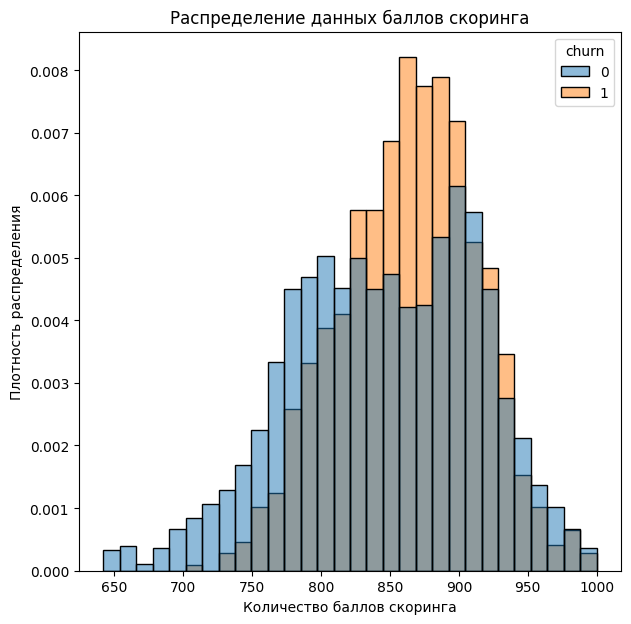

In [ ]:
# Посмотрим на распределение данных баллов скоринга
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=data, x="score", hue="churn", stat="density", common_norm=False, bins = 30)

plt.xlabel("Количество баллов скоринга", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение данных баллов скоринга")
plt.show()

Видим что диапазон кредитного рейтинга с оттоком немного уже. При этом у пользователей склонных к оттоку заметен пик в диапазоне от 820 до 900 баллов скора.

Посмотрим на распределение данных по возрасту

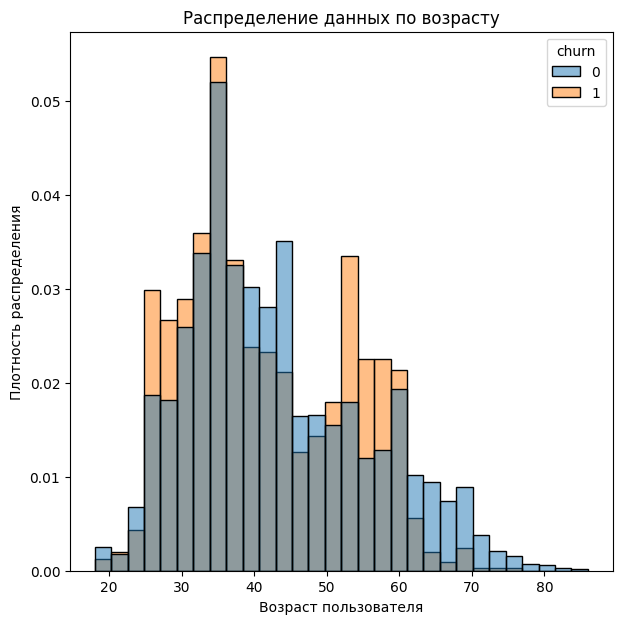

In [ ]:
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=data, x="age", hue="churn", stat="density", common_norm=False, bins = 30)

plt.xlabel("Возраст пользователя", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение данных по возрасту")
plt.show()

Выделяются только группы пользователей в диапазоне от 25 до 30 и от 50 до 60 лет.

Посмотрим на распределение баллов собственности

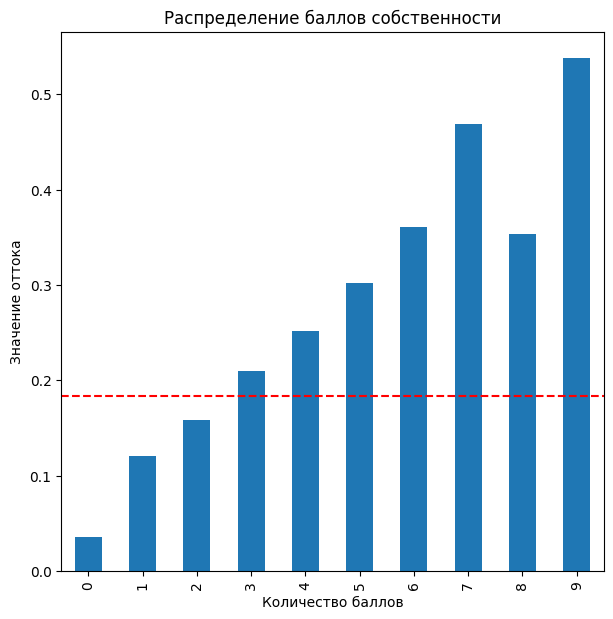

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

data.groupby(['equity'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = data['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Количество баллов", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение баллов собственности")
plt.show()

По графику видно, что отток пользователей начинается а диапазоне от 3 до 9 баллов собственности.

Посмотрим на распределение баланса

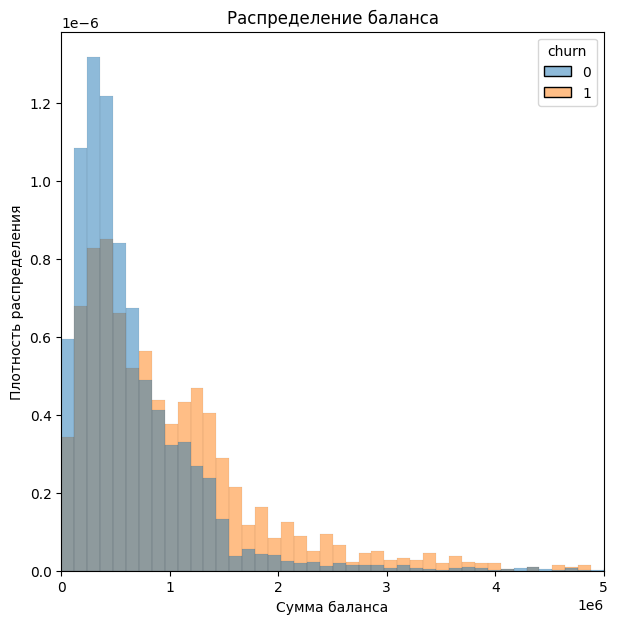

In [ ]:
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=data, x="balance", hue="churn", stat="density", common_norm=False, bins = 1000)

axs.set_xlim([0, 5000000])
plt.xlabel("Сумма баланса", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение баланса")
plt.show()

Видим что более склонны к оттоку те у кого выше баланс.

Посмотрим на распределение количества продуктов

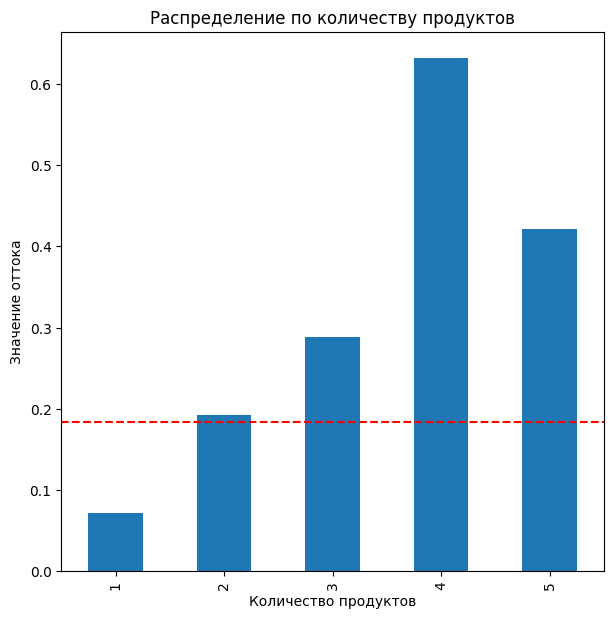

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

data.groupby(['products'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = data['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Количество продуктов", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по количеству продуктов")
plt.show()

более склонны к оттоку пользователи у кого более 2 продуктов.

Посмотрим на распределение по наличию кредитной карты

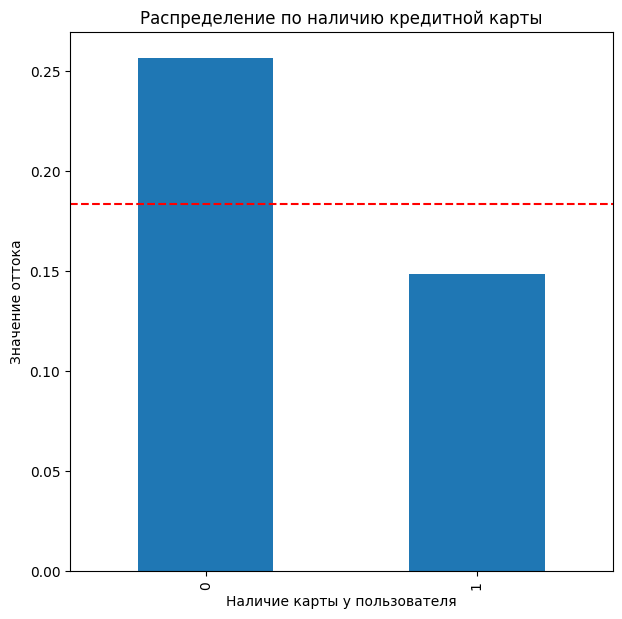

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

data.groupby(['credit_card'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = data['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Наличие карты у пользователя", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по наличию кредитной карты")
plt.show()

Более склонны к оттоку пользователи без крединой карты.

Более склонны к оттоку активные пользователи.

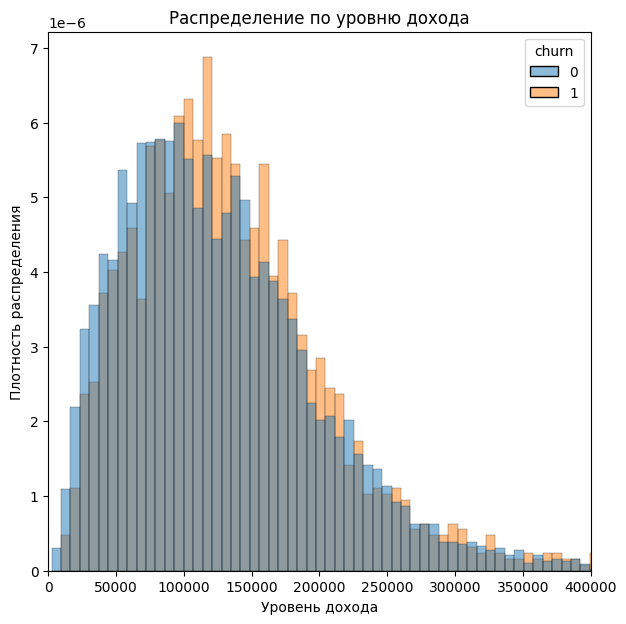

In [ ]:
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=data, x="est_salary", hue="churn", stat="density", common_norm=False, bins = 200)

axs.set_xlim([0, 400000])
plt.xlabel("Уровень дохода", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение по уровню дохода")
plt.show()

Явной разницы не наблюдается, при этом пользователи с большим доходом более склонны к оттоку.

Посмотрим на категориальные признаки город и гендер.

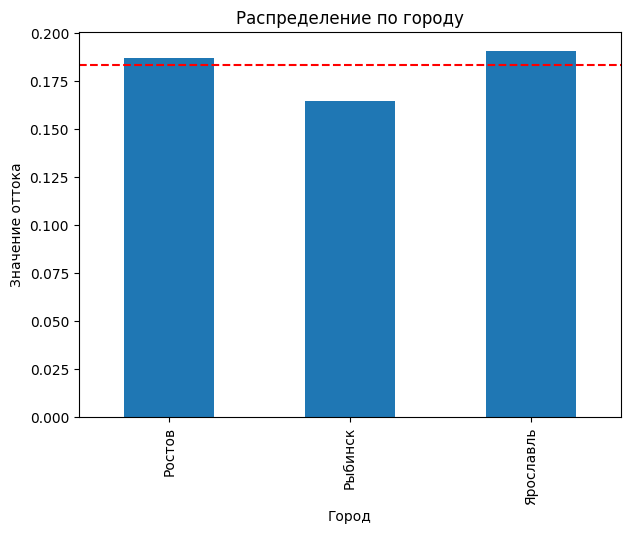

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
data.groupby(['city'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = data['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Город", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по городу")
plt.show()

Значения привышают средний показатель в двух городах: Ростов и Ярославь.

Распределение по гендеру

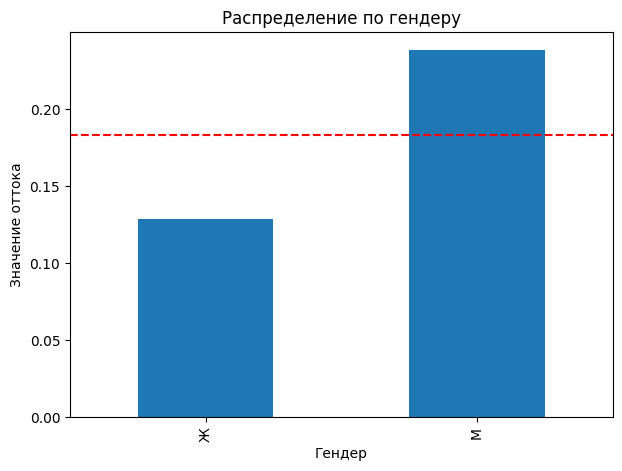

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
data.groupby(['gender'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = data['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Гендер", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по гендеру")
plt.show()

Видим что среднее значение превышено у мужчин.

Корреляционный анализ

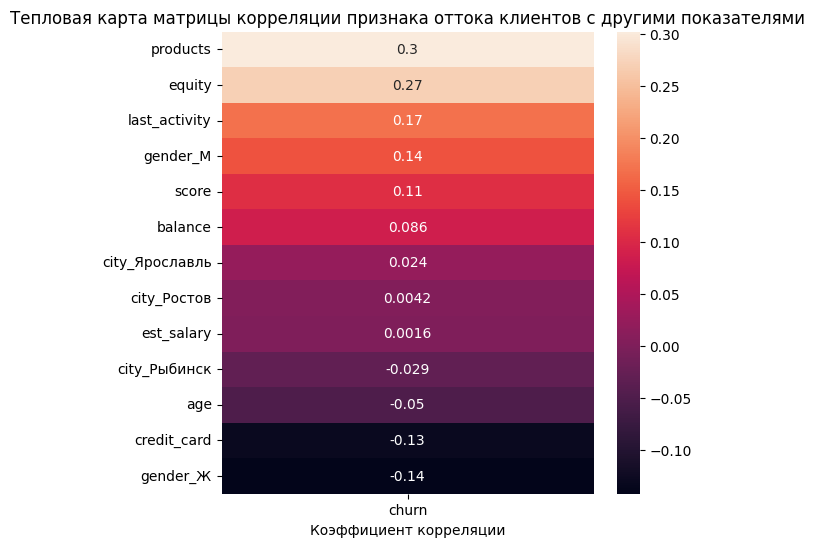

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(pd.DataFrame(data
                         .drop(columns=['city', 'gender', 'user_id'])
                         .corr()['churn']
                         .sort_values(ascending=False)
                         .iloc[1:]),
            annot=True)
plt.title('Тепловая карта матрицы корреляции признака оттока клиентов с другими показателями')
plt.xlabel('Коэффициент корреляции')
plt.show()

На основании полученных данных по столбцу оттока можно сказать, что высокой и очень высокой зависимости между показателем оттока и имеющимися данными не наблюдается. При этом имеется средняя положительная зависимость между оттоком и такими показателями:

Количество продуктов;
Количество баллов собственности;
Активность пользователя.

Со всеми остальными показателями имеется слабая положительная зависимость.

В результате получилось, что наиболее склонны к оттоку пользователи:


*   Из Ростова и Ярославля;
*   Мужчины;
*   Активные пользователи;
*   В наличии более 2 продуктов банка;
*   Без крединой карты;
*   С большим количеством баллов собственности;
*   С более высокой оценкой скора.

In [ ]:
data['balance'] = data['balance'].astype(str).str.replace(',', '').astype(float)
mean_balance = data['balance'].mean(skipna=True)
data['balance'] = data['balance'].fillna(mean_balance)
data['balance'] = data['balance'].round(2)
data_clean = data.drop(['user_id', 'city', 'gender'], axis=1)

In [ ]:
data_clean.head()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Ростов,city_Рыбинск,city_Ярославль
0,850.000,25,1,"59,214.820",2,0,1,"75,719.140",1,True,False,False,True,False
1,861.000,37,5,"850,594.330",3,1,0,"86,621.770",0,True,False,False,True,False
2,892.000,30,0,"828,206.270",1,1,1,"107,683.340",0,True,False,False,True,False
3,866.000,51,5,"1,524,746.260",2,0,1,"174,423.530",1,True,False,False,False,True
4,730.000,34,5,174.000,1,1,0,"67,353.160",1,False,True,False,False,True


### 4.Построение и оценка моделей

In [ ]:

X = data_clean.drop('churn', axis=1)
y = data_clean['churn']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


Model: LogisticRegression
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Training time: 8.12 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.83      1621
           1       0.41      0.74      0.52       364

    accuracy                           0.75      1985
   macro avg       0.67      0.75      0.68      1985
weighted avg       0.83      0.75      0.78      1985

ROC-AUC: 0.821
PR-AUC: 0.509


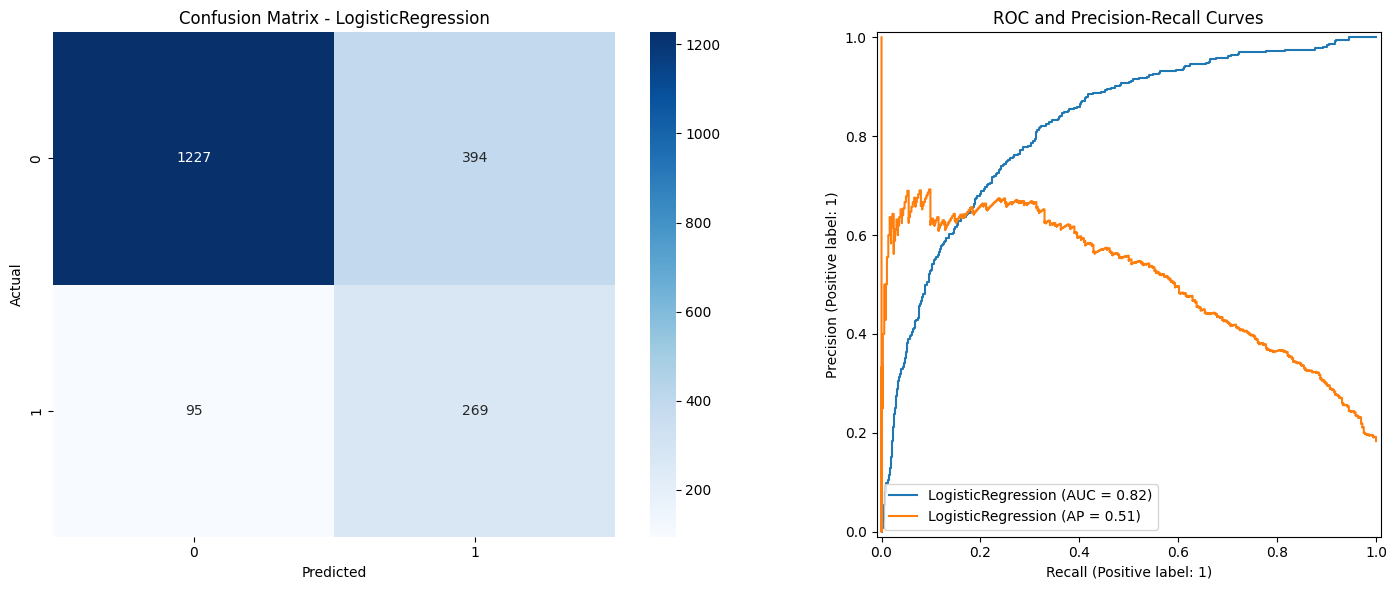


Model: RandomForest
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Training time: 128.50 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1621
           1       0.64      0.63      0.64       364

    accuracy                           0.87      1985
   macro avg       0.78      0.78      0.78      1985
weighted avg       0.87      0.87      0.87      1985

ROC-AUC: 0.891
PR-AUC: 0.707


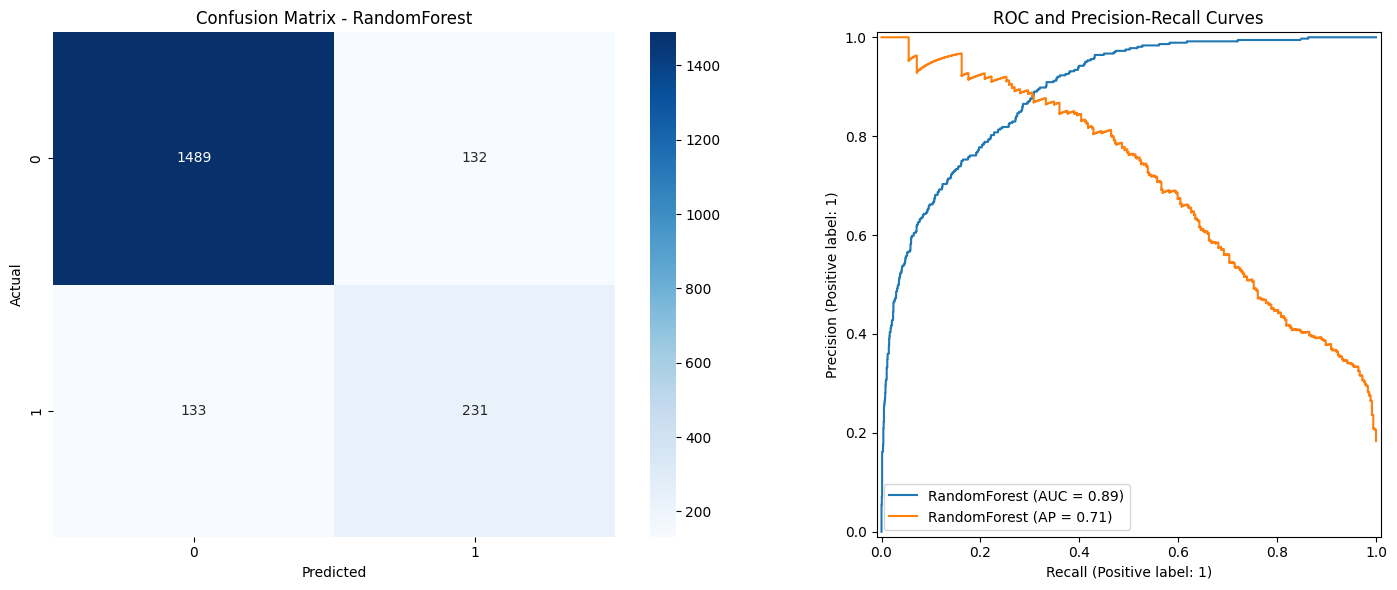


Model: XGBoost
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}
Training time: 13.32 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1621
           1       0.46      0.83      0.59       364

    accuracy                           0.79      1985
   macro avg       0.71      0.80      0.72      1985
weighted avg       0.86      0.79      0.81      1985

ROC-AUC: 0.894
PR-AUC: 0.709


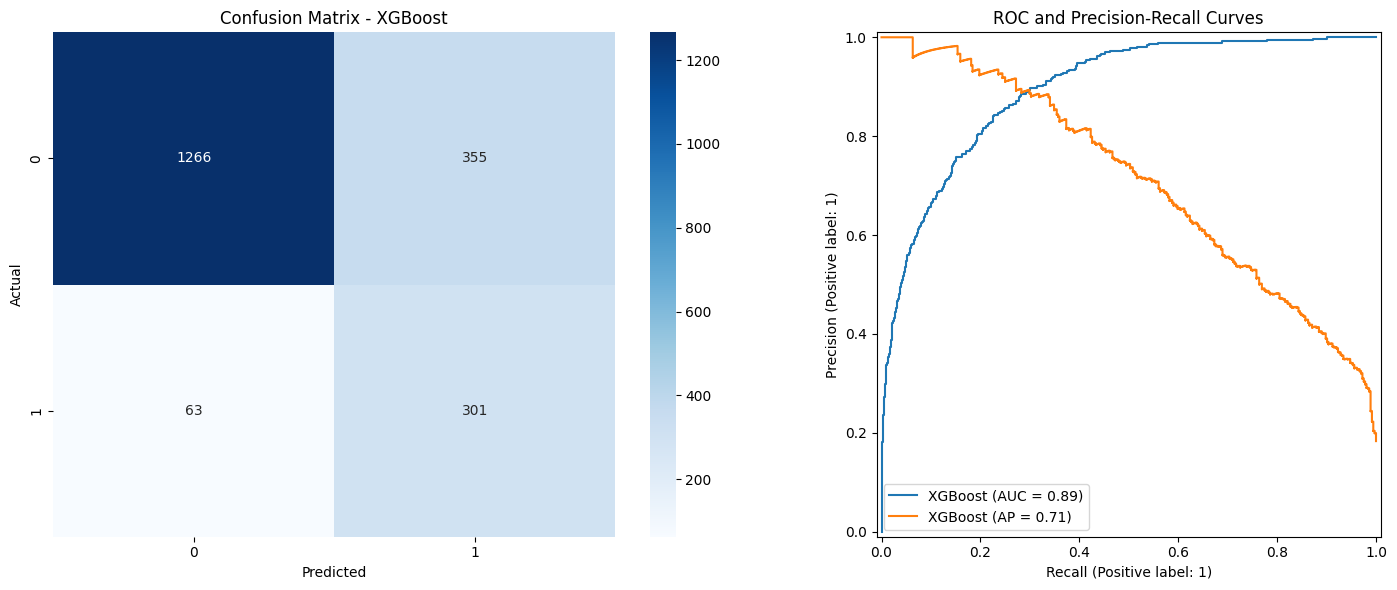


Best model: RandomForest
Best F1-Score: 0.635


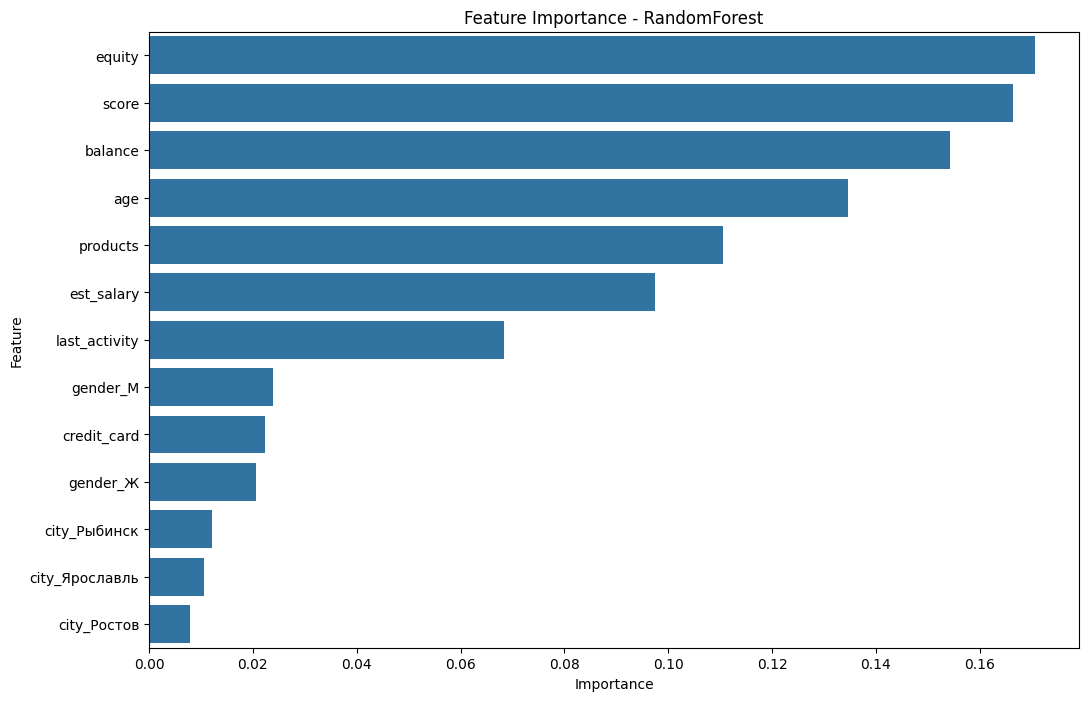


Summary Results Table:


,Model,Best Params,Precision (Churn=1),Recall (Churn=1),F1 (Churn=1),ROC-AUC,PR-AUC,Train Time (s),Best Model
1,RandomForest,"{'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}",0.636,0.635,0.635,0.891,0.707,128.5,"Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('classifier', RandomForestClassifier(class_weight='balanced', min_samples_split=5, n_estimators=200, random_state=42))])"
2,XGBoost,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}",0.459,0.827,0.590,0.894,0.709,13.3,"Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('classifier', XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=6, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=200, n_jobs=None, num_parallel_tree=None, random_state=42, ...))])"
0,LogisticRegression,"{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}",0.406,0.739,0.524,0.821,0.509,8.1,"Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('classifier', LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42, solver='liblinear'))])"


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report,
                           roc_auc_score,
                           average_precision_score,
                           confusion_matrix,
                           PrecisionRecallDisplay,
                           RocCurveDisplay)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

try:
    from xgboost import XGBClassifier
    XGB_INSTALLED = True
except ImportError:
    XGB_INSTALLED = False
    print("XGBoost не установлен. Будут использованы только LogisticRegression и RandomForest")

def evaluate_models_with_hyperparams(X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)


    models_params = {
        'LogisticRegression': {
            'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
            'params': {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear']
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(class_weight='balanced', random_state=42),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [None, 10, 20],
                'classifier__min_samples_split': [2, 5]
            }
        }
    }

    if XGB_INSTALLED:
        scale_pos_weight = sum(y==0)/sum(y==1) if sum(y==1) > 0 else 1
        models_params['XGBoost'] = {
            'model': XGBClassifier(scale_pos_weight=scale_pos_weight,
                                 random_state=42,
                                 eval_metric='logloss'),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [3, 6],
                'classifier__learning_rate': [0.01, 0.1]
            }
        }

    results = []

    for name, mp in models_params.items():
        start_time = time()


        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('classifier', mp['model'])
        ])


        grid = GridSearchCV(
            pipeline,
            mp['params'],
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=0
        )


        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:, 1]


        report = classification_report(y_test, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred)


        train_time = time() - start_time


        results.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'Precision (Churn=1)': report['1']['precision'],
            'Recall (Churn=1)': report['1']['recall'],
            'F1 (Churn=1)': report['1']['f1-score'],
            'ROC-AUC': roc_auc,
            'PR-AUC': pr_auc,
            'Train Time (s)': train_time,
            'Best Model': grid.best_estimator_
        })


        print(f"\n{'='*50}")
        print(f"Model: {name}")
        print(f"Best parameters: {grid.best_params_}")
        print(f"Training time: {train_time:.2f} seconds")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"PR-AUC: {pr_auc:.3f}")


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
        ax1.set_title(f'Confusion Matrix - {name}')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')


        RocCurveDisplay.from_estimator(grid, X_test, y_test, ax=ax2, name=name)
        PrecisionRecallDisplay.from_estimator(grid, X_test, y_test, ax=ax2, name=name)
        ax2.set_title('ROC and Precision-Recall Curves')

        plt.tight_layout()
        plt.show()


    results_df = pd.DataFrame(results).sort_values('F1 (Churn=1)', ascending=False)


    best_model_info = results_df.iloc[0]
    print("\n" + "="*50)
    print(f"Best model: {best_model_info['Model']}")
    print(f"Best F1-Score: {best_model_info['F1 (Churn=1)']:.3f}")

    if hasattr(best_model_info['Best Model'].named_steps['classifier'], 'feature_importances_'):
        feature_importances = best_model_info['Best Model'].named_steps['classifier'].feature_importances_
        features = X.columns
        fi_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        fi_df = fi_df.sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=fi_df)
        plt.title(f'Feature Importance - {best_model_info["Model"]}')
        plt.show()

    return results_df, best_model_info['Best Model']


results_df, best_model = evaluate_models_with_hyperparams(X, y)


print("\nSummary Results Table:")
display(results_df.style
      .background_gradient(subset=['F1 (Churn=1)', 'ROC-AUC', 'PR-AUC'], cmap='YlGn')
      .format({'Precision (Churn=1)': '{:.3f}',
               'Recall (Churn=1)': '{:.3f}',
               'F1 (Churn=1)': '{:.3f}',
               'ROC-AUC': '{:.3f}',
               'PR-AUC': '{:.3f}',
               'Train Time (s)': '{:.1f}'}))

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


logreg = LogisticRegression(C=1, penalty='l2', solver='liblinear', class_weight='balanced')
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, class_weight='balanced')

if XGB_INSTALLED:
    xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1)


estimators = [
    ('logreg', logreg),
    ('rf', rf)
]

if XGB_INSTALLED:
    estimators.append(('xgb', xgb))


voting_hard = VotingClassifier(estimators=estimators, voting='hard')

voting_soft = VotingClassifier(estimators=estimators, voting='soft')


voting_pipeline_hard = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_hard)
])

voting_pipeline_soft = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_soft)
])


for name, pipeline in [('Hard Voting', voting_pipeline_hard), ('Soft Voting', voting_pipeline_soft)]:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if name == 'Soft Voting' else None

    print(f"\n{name} Classifier:")
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
        print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


Hard Voting Classifier:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1621
           1       0.64      0.66      0.65       364

    accuracy                           0.87      1985
   macro avg       0.78      0.79      0.78      1985
weighted avg       0.87      0.87      0.87      1985


Soft Voting Classifier:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1621
           1       0.61      0.66      0.64       364

    accuracy                           0.86      1985
   macro avg       0.77      0.78      0.78      1985
weighted avg       0.87      0.86      0.86      1985

ROC-AUC: 0.896
PR-AUC: 0.718


In [ ]:
from sklearn.ensemble import BaggingClassifier


base_clf = RandomForestClassifier(max_depth=20,
                                min_samples_split=5,
                                class_weight='balanced',
                                random_state=42)


bagging = BaggingClassifier(
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42
)


bagging_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('bagging', bagging)
])


bagging_pipeline.fit(X_train, y_train)
y_pred = bagging_pipeline.predict(X_test)
y_proba = bagging_pipeline.predict_proba(X_test)[:, 1]

print("\nBagging Classifier:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")




Bagging Classifier:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1621
           1       0.61      0.63      0.62       364

    accuracy                           0.86      1985
   macro avg       0.76      0.77      0.77      1985
weighted avg       0.86      0.86      0.86      1985

ROC-AUC: 0.889
PR-AUC: 0.690


In [ ]:

ensembles = [
    ('Hard Voting', voting_pipeline_hard),
    ('Soft Voting', voting_pipeline_soft),
    ('Bagging', bagging_pipeline)
]


results = []
for name, model in ensembles:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        'Model': name,
        'Precision (Churn=1)': report['1']['precision'],
        'Recall (Churn=1)': report['1']['recall'],
        'F1 (Churn=1)': report['1']['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'PR-AUC': average_precision_score(y_test, y_proba) if y_proba is not None else None
    }
    results.append(metrics)


ensemble_results = pd.DataFrame(results).sort_values('F1 (Churn=1)', ascending=False)
print("\nСравнение ансамблей:")
display(ensemble_results.style
       .background_gradient(subset=['F1 (Churn=1)', 'ROC-AUC', 'PR-AUC'], cmap='YlGn')
       .format({'Precision (Churn=1)': '{:.3f}',
                'Recall (Churn=1)': '{:.3f}',
                'F1 (Churn=1)': '{:.3f}',
                'ROC-AUC': '{:.3f}',
                'PR-AUC': '{:.3f}'}))


Сравнение ансамблей:


,Model,Precision (Churn=1),Recall (Churn=1),F1 (Churn=1),ROC-AUC,PR-AUC
0,Hard Voting,0.637,0.657,0.647,nan,nan
1,Soft Voting,0.611,0.665,0.637,0.896,0.718
2,Bagging,0.609,0.629,0.619,0.889,0.690


Выыоды по оценке моделей:

Лучшая модель по F1-score (0.647) — Hard Voting

Объединяет предсказания Random Forest, XGBoost и Logistic Regression.

Дает баланс между точностью (Precision) и полнотой (Recall).

XGBoost показал наивысший Recall (0.827)

Хорошо выявляет уходящих клиентов, но страдает низкой точностью (много ложных срабатываний).

Logistic Regression — самая слабая модель

Низкая точность  из-за линейности данных.




### Топ признаков на которые ориентировалась модель Hard voting

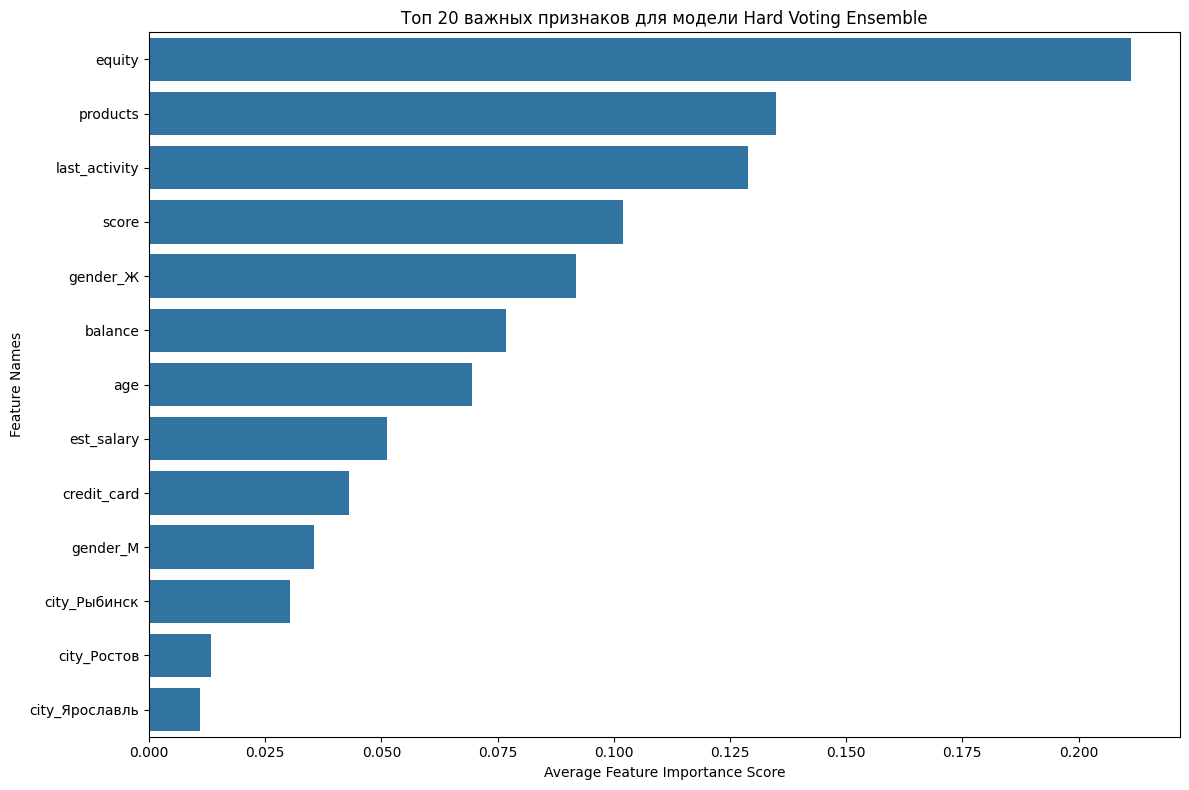


Top 20 features by average importance:
                Average Importance
equity                       0.211
products                     0.135
last_activity                0.129
score                        0.102
gender_Ж                     0.092
balance                      0.077
age                          0.070
est_salary                   0.051
credit_card                  0.043
gender_М                     0.035
city_Рыбинск                 0.030
city_Ростов                  0.013
city_Ярославль               0.011


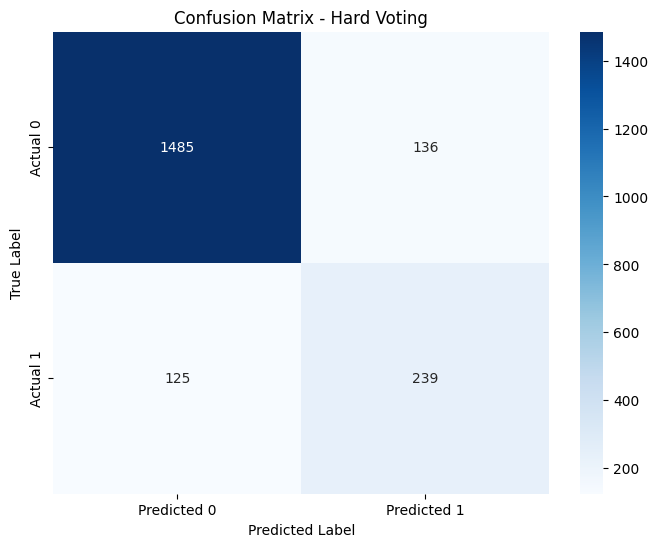


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1621
           1       0.64      0.66      0.65       364

    accuracy                           0.87      1985
   macro avg       0.78      0.79      0.78      1985
weighted avg       0.87      0.87      0.87      1985



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def analyze_hard_voting_model(pipeline, X_train, y_train, X_test, y_test, feature_names=None, top_features=20):


    voting_clf = pipeline.named_steps['voting']


    if feature_names is None:
        try:
            feature_names = X_train.columns.tolist()
        except AttributeError:
            feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]


    importance_df = pd.DataFrame(index=feature_names)


    for name, model in voting_clf.named_estimators_.items():
        try:
            if hasattr(model, 'feature_importances_'):

                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):

                importances = np.abs(model.coef_[0])
            else:
                continue

            importances = importances / importances.sum()
            importance_df[name] = importances

        except Exception as e:
            print(f"Не удалось получить важность признаков для {name}: {str(e)}")


    if not importance_df.empty:
        importance_df['Average Importance'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('Average Importance', ascending=False)


        plot_df = importance_df.head(top_features).reset_index()
        plot_df.rename(columns={'index': 'Feature'}, inplace=True)


        plt.figure(figsize=(12, 8))
        sns.barplot(x='Average Importance',
                    y='Feature',
                    data=plot_df,
                    order=plot_df['Feature'])
        plt.title(f'Топ {top_features} важных признаков для модели Hard Voting Ensemble')
        plt.xlabel('Average Feature Importance Score')
        plt.ylabel('Feature Names')
        plt.tight_layout()
        plt.show()


        print(f"\nTop {top_features} features by average importance:")
        print(importance_df[['Average Importance']].head(top_features))


    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix - Hard Voting')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return importance_df


feature_importance_df = analyze_hard_voting_model(
    pipeline=voting_pipeline_hard,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=X.columns,
    top_features=20
)

# 5.Интерпретация результатов

Основные проблемы

Низкая точность для класса Churn=1 (много ложных срабатываний).
Дисбаланс классов (18% уходящих) усложняет обучение.


Ревью процесса:

Что сработало хорошо:

Ансамбли (Voting) улучшили F1-score на 2% по сравнению с лучшей одиночной моделью (RF).

SMOTE + GridSearchCV помогли настроить модели.

ROC-AUC > 0.89 у всех топ-моделей.

Что можно улучшить:

Feature Engineering: Создать новые признаки (например, отношение баланса к зарплате).


Оптимизация порога классификации: Сейчас используется 0.5, но можно подобрать порог по бизнес-метрикам.



Следующие шаги:
Внедрение:
Развернуть Hard Voting или Random Forest в production (как наиболее сбалансированные)

# Обработка голосовых отзывов

In [14]:
import os
import sqlite3
from pydub import AudioSegment
import speech_recognition as sr
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

class CallAnalysisSystem:
    def __init__(self, db_path='call_analysis.db'):
        self.db_path = db_path
        self._init_db()
        self.sentiment_analyzer = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")
        self.recognizer = sr.Recognizer()

    def _init_db(self):
        """Инициализация базы данных"""
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()
            cursor.execute('''
                CREATE TABLE IF NOT EXISTS calls (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    call_date TEXT NOT NULL,
                    duration INTEGER,
                    phone_number TEXT,
                    employee_id TEXT,
                    transcript TEXT,
                    sentiment TEXT,
                    topic TEXT,
                    issues TEXT,
                    file_path TEXT
                )
            ''')
            conn.commit()

    def save_call(self, file_path, phone_number=None, employee_id=None):
        """Обработка и сохранение звонка с выводом результатов"""
        print(f"\nОбработка файла: {file_path}")


        print("Конвертация аудио...")
        audio = self._convert_audio(file_path)


        print("Транскрипция аудио...")
        transcript = self._transcribe_audio(audio)
        print("\n=== Транскрипция ===")
        print(transcript)


        print("\nАнализ тональности...")
        sentiment = self._analyze_sentiment(transcript)
        print("=== Тональность ===")
        print(sentiment)


        topic = self._classify_topic(transcript)
        print("\n=== Тема обращения ===")
        print(topic)


        issues = self._extract_issues(transcript)
        print("\n=== Проблемы ===")
        print(issues)

        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()
            cursor.execute('''
                INSERT INTO calls (
                    call_date, duration, phone_number, employee_id,
                    transcript, sentiment, topic, issues, file_path
                ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                datetime.now().isoformat(),
                len(audio),
                phone_number,
                employee_id,
                transcript,
                sentiment,
                topic,
                issues,
                file_path
            ))
            conn.commit()

        print("\nДанные успешно сохранены в базу!")
        return {
            'transcript': transcript,
            'sentiment': sentiment,
            'topic': topic,
            'issues': issues
        }

    def _convert_audio(self, file_path):
        """Конвертация аудио в WAV формат"""
        if not file_path.endswith('.wav'):
            sound = AudioSegment.from_file(file_path)
            wav_path = os.path.splitext(file_path)[0] + '.wav'
            sound.export(wav_path, format="wav")
            return AudioSegment.from_wav(wav_path)
        return AudioSegment.from_wav(file_path)

    def _transcribe_audio(self, audio):
        """Транскрипция аудио в текст"""
        wav_path = "temp.wav"
        audio.export(wav_path, format="wav")

        with sr.AudioFile(wav_path) as source:
            audio_data = self.recognizer.record(source)
            try:
                text = self.recognizer.recognize_google(audio_data, language="ru-RU")
                return text
            except sr.UnknownValueError:
                return "Не удалось распознать речь"
            except sr.RequestError:
                return "Ошибка сервиса распознавания"

    def _analyze_sentiment(self, text):
        """Анализ тональности текста"""
        if len(text.split()) < 3 or text in ["Не удалось распознать речь", "Ошибка сервиса распознавания"]:
            return "neutral"
        result = self.sentiment_analyzer(text[:512])
        return result[0]['label']

    def _classify_topic(self, text):
        """Классификация темы обращения"""
        topics = {
            'кэшбек': ['кэш', 'кэшбэка', 'кэшбэк', 'баллы'],
            'карты': ['карт', 'карточк', 'платеж', 'перевод'],
            'кредиты': ['кредит', 'займ', 'ссуд', 'платеж'],
            'вклады': ['вклад', 'депозит', 'процент', 'накоплен'],
            'обслуживание': ['обслуж', 'отделен', 'банкомат', 'очеред']
        }

        text_lower = text.lower()
        for topic, keywords in topics.items():
            if any(keyword in text_lower for keyword in keywords):
                return topic
        return 'другое'

    def _extract_issues(self, text):
        """Извлечение проблем из текста"""
        issue_keywords = ['проблем', 'ошибк', 'не работ', 'не могу', 'жалоб', 'заморозили', 'заблокировали', 'глупые', 'наглые', 'требую']
        if any(keyword in text.lower() for keyword in issue_keywords):
            return "есть проблемы"
        return "нет проблем"

    def generate_reports(self, start_date=None, end_date=None):
        """Генерация аналитических отчетов"""
        with sqlite3.connect(self.db_path) as conn:
            query = "SELECT * FROM calls"
            if start_date and end_date:
                query += f" WHERE call_date BETWEEN '{start_date}' AND '{end_date}'"
            df = pd.read_sql(query, conn)

        if df.empty:
            print("Нет данных для отчетов")
            return None


        topic_counts = df['topic'].value_counts()


        sentiment_counts = df['sentiment'].value_counts()


        issue_counts = df['issues'].value_counts()


        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        topic_counts.plot(kind='bar', color='skyblue')
        plt.title('Распределение по темам')

        plt.subplot(2, 2, 2)
        sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightblue'])
        plt.title('Распределение тональности')

        plt.subplot(2, 2, 3)
        issue_counts.plot(kind='barh', color=['salmon', 'lightgreen'])
        plt.title('Наличие проблем в обращениях')

        plt.tight_layout()
        report_path = f"report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(report_path)
        plt.close()

        print("\n=== Аналитический отчет ===")
        print(f"Распределение по темам:\n{topic_counts.to_dict()}")
        print(f"\nРаспределение тональности:\n{sentiment_counts.to_dict()}")
        print(f"\nНаличие проблем:\n{issue_counts.to_dict()}")
        print(f"\nПолный отчет сохранен в: {report_path}")

        return {
            'topic_distribution': topic_counts.to_dict(),
            'sentiment_distribution': sentiment_counts.to_dict(),
            'issues_distribution': issue_counts.to_dict(),
            'report_image': report_path
        }

    def get_calls(self, filters=None):
        """Получение записей звонков с возможностью фильтрации"""
        with sqlite3.connect(self.db_path) as conn:
            query = "SELECT * FROM calls"
            if filters:
                conditions = []
                params = []
                for key, value in filters.items():
                    if value:
                        conditions.append(f"{key} = ?")
                        params.append(value)
                if conditions:
                    query += " WHERE " + " AND ".join(conditions)
            df = pd.read_sql(query, conn, params=params if filters else None)

        if not df.empty:
            print("\n=== Найденные записи ===")
            for _, row in df.iterrows():
                print(f"\nID: {row['id']}")
                print(f"Дата: {row['call_date']}")
                print(f"Телефон: {row['phone_number']}")
                print(f"Сотрудник: {row['employee_id']}")
                print(f"\nТранскрипция:\n{row['transcript']}")
                print(f"\nТональность: {row['sentiment']}")
                print(f"Тема: {row['topic']}")
                print(f"Проблемы: {row['issues']}")
                print("-" * 50)
        else:
            print("Записи не найдены")

        return df


if __name__ == "__main__":
    system = CallAnalysisSystem()


    result = system.save_call("/content/ttsmaker-file-2025-5-16-19-38-30 (online-audio-converter.com).wav", "+79123456349", "emp_123")


    report = system.generate_reports()


    print("\nПоиск записей по фильтру...")
    calls_data = system.get_calls({'topic': 'кэшбек', 'sentiment': 'NEGATIVE'})

Device set to use cpu



Обработка файла: /content/ttsmaker-file-2025-5-16-19-38-30 (online-audio-converter.com).wav
Конвертация аудио...
Транскрипция аудио...

=== Транскрипция ===
меня заблокировали и деньги все заморозили там вся моя зарплата была на обращение в банк обязали писать заявление и 47 дней ждать вывода средств сегодня уже больше полугода банк мне средства не возвращает без каких-либо комментариев в отделении банка Мне жмут плечами говорят что подождать ещё нужно а на горячей линии говорят что только через отделение решать и нет никакого сервиса поддержки Кто бы мог разрешить ситуацию по данному вопросу

Анализ тональности...
=== Тональность ===
NEGATIVE

=== Тема обращения ===
обслуживание

=== Проблемы ===
есть проблемы

Данные успешно сохранены в базу!

=== Аналитический отчет ===
Распределение по темам:
{'кэшбек': 1, 'обслуживание': 1}

Распределение тональности:
{'NEGATIVE': 2}

Наличие проблем:
{'есть проблемы': 2}

Полный отчет сохранен в: report_20250516_165843.png

Поиск записей по филь

In [15]:
import sqlite3
from tabulate import tabulate

def display_database_contents(db_path='call_analysis.db'):
    """Выводит содержимое базы данных в удобочитаемом формате"""
    try:

        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()


        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        if not tables:
            print("В базе данных нет таблиц.")
            return

        print("\n" + "="*50)
        print(f"СОДЕРЖИМОЕ БАЗЫ ДАННЫХ: {db_path}")
        print("="*50)

        for table in tables:
            table_name = table[0]


            cursor.execute(f"PRAGMA table_info({table_name});")
            columns = cursor.fetchall()
            column_names = [col[1] for col in columns]


            cursor.execute(f"SELECT * FROM {table_name};")
            rows = cursor.fetchall()

            print("\n" + "-"*50)
            print(f"ТАБЛИЦА: {table_name.upper()}")
            print(f"Колонки: {', '.join(column_names)}")
            print(f"Количество записей: {len(rows)}")
            print("-"*50)

            if rows:

                print(tabulate(rows, headers=column_names, tablefmt="grid"))
            else:
                print("Таблица пуста.")

            print("-"*50)

        print("\n" + "="*50)
        print("ВЫВОД ЗАВЕРШЕН")
        print("="*50)

    except sqlite3.Error as e:
        print(f"Ошибка при работе с базой данных: {e}")
    finally:
        if conn:
            conn.close()

if __name__ == "__main__":
    print("Вывод содержимого базы данных...\n")
    display_database_contents()

Вывод содержимого базы данных...


СОДЕРЖИМОЕ БАЗЫ ДАННЫХ: call_analysis.db

--------------------------------------------------
ТАБЛИЦА: CALLS
Колонки: id, call_date, duration, phone_number, employee_id, transcript, sentiment, topic, issues, file_path
Количество записей: 2
--------------------------------------------------
+------+----------------------------+------------+----------------+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+--------------+---------------+----------------------------------------------------------------------------+
|   id | call_date      